In [1]:
import numpy as np
from homography import pyrs12, spaces
import cv2, h5py, deproject, HandShapeAnalysis
import matplotlib.pyplot as plt
import pptk
# np.set_printoptions(threshold=np.inf)

In [2]:
def plt_imsize(image,size=(10,10)):
    fig1 = plt.figure(figsize=size) # create a figure with the default size 
    ax1 = fig1.add_subplot(1,1,1) 
    ax1.imshow(image, interpolation='none')
    plt.show()

In [3]:
one = h5py.File('../recording_data/labeled/1_move_down_yes.hdf5', 'r')
org = one['pcl_center'][...]
mat = one['trans_matrix'][...]
analyser = HandShapeAnalysis.Depth2Finger(org, mat)
analyser.set_show(debug = True, finger_point_image = True, hull_image = True, detected_defect = True, 
                  cluster_point= True,  possibility_modal = False)

In [4]:
print(org)

[-0.02304791  0.0055409   0.36371115]


In [36]:
def depth2cloud(image, mat, org, show = False):
    cloud = deproject.compute(image.astype(np.short()))
    point_original = (np.dot(mat, (cloud - org).reshape((-1,3)).T).T)
    point = point_original.reshape((480,640,3))
    if show: plt.imshow(point[image != 0].reshape((-1,3)))
    return point[image != 0].reshape((-1,3))#, point[without_table].reshape((-1,3))

In [37]:
x = depth2cloud(one['depth'][len(one['color'])-1], mat, org)

In [38]:
(x[...,0] >= 0).shape

(248562,)

In [6]:
def cloud2bird_image(cloud, ratio):
    #filter
    cloud = cloud.reshape((-1,3))
    #normalise x, y, z axis
    cloud[:,0] = cloud[:,0]-np.min(cloud[:,0])
    cloud[:,0] = cloud[:,0]/np.max(cloud[:,0])
    
    cloud[:,1] = cloud[:,1]-np.min(cloud[:,1])
    cloud[:,1] = cloud[:,1]/np.max(cloud[:,1])

    #point cloud to 2d gray image
    xaxis = 300
    size = (np.int(xaxis * ratio), xaxis)#(y-axis, x-axis)
    core = np.array([[size[1]-10,0,0],[0,size[0]-10,0],[0,0,1]])
    r = np.dot(cloud, core)
    r = r[np.argsort(r[:,2])]#so that, higher point overwrite lower
    image = np.zeros(size)
    image[r[:,1].astype(np.int),r[:,0].astype(np.int)] = r[:,2]#align the coordinate to image data
    return image[:,::-1]##point cloud left x increase, however image reduce to 0, so [:,1] to show

In [7]:
def ROI_filter(obj):
    heightCm = 16.93
    widthCm = 25.4

    xmin = - widthCm / 100 / 2
    xmax = widthCm / 100 / 2
    ymin = - heightCm / 100 / 2
    ymax = heightCm / 100 / 2

    ## add 5cm margin
    margin = 0.05
    xmin_ = xmin - margin
    xmax_ = xmax + margin
    ymin_ = ymin - 0.1##give the clear hand image when finger touching the edge
    ymax_ = ymax + margin
    xm = (obj[:,0] >= xmin_) & (obj[:,0] <= xmax_)
    ym = (obj[:,1] >= ymin_) & (obj[:,1] <= ymax_)
    ratio = ((np.abs(ymin_) + ymax_)/(np.abs(xmin_) + xmax_))
    
    return obj[xm & ym], ratio

In [8]:
def renew_high(image, mat, org):
    point, ratio= ROI_filter(depth2cloud(image, mat, org))
#     point_without_table = point[point[:,2]>0.01]
    image = cloud2bird_image(point, ratio)
    image = np.where(image>0.01, image,0)
    #normalize pointcloud z axis to image data
    image = image-np.min(image)
    image = (image/np.max(image))*255##use z axis
    
    analyser.renew_test(image.astype(np.uint8))
    plt_imsize(np.concatenate((analyser.finger_point_image, analyser.detected_defect, analyser.finger_point_image),axis =1))
    print(analyser.finger_point_image.shape)
    print(analyser.finger_point)
    
    

[[194   0]
 [191  28]
 [151  87]
 [118  23]
 [134   0]]
[ 90.6930603   27.14802938 131.9872125 ]


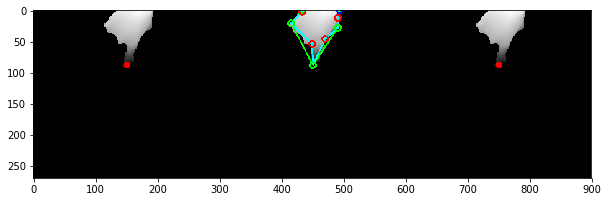

(270, 300, 3)
[[151  88]]


In [9]:
renew_high(one['depth'][len(one['color'])-1], mat, org)

[[194   0]
 [191  28]
 [151  87]
 [118  23]
 [134   0]]
[ 90.6930603   27.14802938 131.9872125 ]


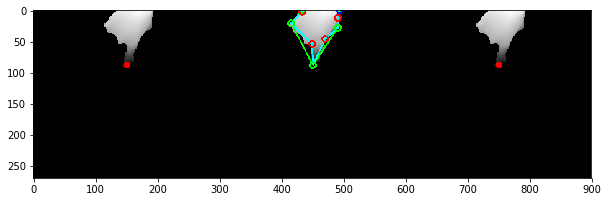

In [10]:
analyser.renew_high(one['depth'][len(one['color'])-1])
plt_imsize(np.concatenate((analyser.finger_point_image, analyser.detected_defect, analyser.finger_point_image),axis =1))
    

[[273   0]
 [158 207]
 [124 136]
 [228   9]]
[ 75.28362377 137.19311804  86.59273038  17.89545649]


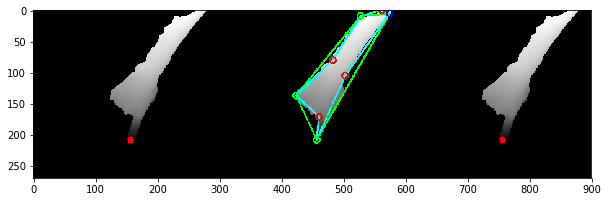

(270, 300, 3)
[[157 208]]


In [11]:
renew_high(one['depth'][0], mat, org)

In [12]:
analyser.renew_depth(one['depth'][0])
analyser.finger_point

[[639 113]
 [282 313]
 [234 185]
 [230 145]
 [252 118]
 [318  55]
 [393   0]
 [639   0]]
[135.21116285 155.77225468 170.53767779 154.31185656 149.62087399
  25.30524912]


array([[280, 314]], dtype=int32)

In [13]:
one = h5py.File('../recording_data/labeled/1_move_down_not.hdf5', 'r')
org = one['pcl_center'][...]
mat = one['trans_matrix'][...]

[[195  10]
 [160  90]
 [127   3]]
[172.05652819 110.44896644  58.75419901]


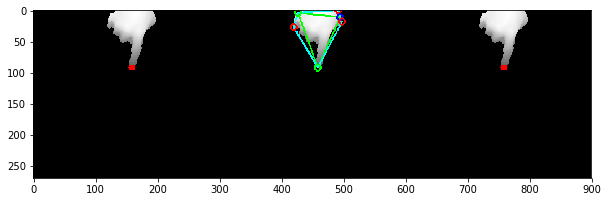

(270, 300, 3)
[[159  92]]


In [14]:
renew_high(one['depth'][len(one['color'])-1], mat, org)

[[247   0]
 [161 219]
 [124 169]
 [113 146]
 [127 118]
 [152  78]
 [203  13]]
[ 55.59733515 140.14374844 119.7448813  157.0871716   88.09084757
 113.80594352  19.81837813]


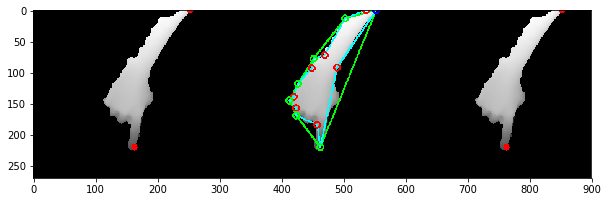

(270, 300, 3)
[[163 220]
 [253   0]]


In [15]:
renew_high(one['depth'][0], mat, org)